# Area Detectors

Working with EPICS areaDetectors in Ophyd follows the same paradigms as motors and other hardware: they're heirarchically composed `Device`s. Albeit, they can be significantly more complex to assemble than simple motors, as areaDetectors permit a 'plugin'-based architecture. This design permits on-demand addition of statistical analysis, file storage, image processing and more.

In this tutorial, we will construct an areaDetector based on the "SimDetector" executing in our simulated hardware environment. The device will be configured with Image, Stats, and TIFF plugins.

First, it is necessary to import the required classes:

In [1]:
from ophyd import (SimDetector, SingleTrigger, TIFFPlugin,
                   ImagePlugin, StatsPlugin, Component as Cpt)

In [7]:
from ophyd.areadetector.filestore_mixins import FileStoreTIFFIterativeWrite

The addition of file-writing capacity requires an appropriate Plugin. Here, TIFF is used, but there are other options available including HDF5. Further integration of file generation with the `FileStore` component is achieved with the addition of a suitable _mixin_ class.

In [8]:
class FileStoreTiffPlugin(TIFFPlugin, FileStoreTIFFIterativeWrite):
    pass

As with the `PVPositioner` example, a `FakeDetector` class is constructed here and composed of an `ImagePlugin`, a `StatsPlugin`, and a `FileStoreTiffPlugin`. The latter is not strictly required to produce TIFF files, but it is necessary for integration with `FileStore`. If such integration is not desired, simply use a plain `TIFFPlugin` instead of the `FileStoreTiffPlugin`.

In [12]:
class FakeDetector(SingleTrigger, SimDetector):
    image = Cpt(ImagePlugin, 'image1:')
    stats1 = Cpt(StatsPlugin, 'Stats1:')
    
    tiff = Cpt(FileStoreTiffPlugin, suffix='TIFF1:',
               write_path_template='/tmp')


Instantiate a `FakeDetector`, and check its connectivity to the EPICS pv's that it contains:

In [13]:
fakecam = FakeDetector('sim:det:', name='fakecam')

In [14]:
fakecam.connected

True

The primary function of any detector is to provide some physical measurement via a `read` operation. Devices in Ophyd are equipped with a `read_attrs` attribute that serves to filter the information that a `read` operation will return.

In [15]:
fakecam.read_attrs

['cam', 'image', 'stats1', 'tiff']

Here we see that the `cam`, `image`, `stats1`, and `tiff` components will all contribute to the output of a `read` operation. This operation will recurse through each of these components and their sub-components.

This is going to be a lot of extraneous data, much of which is not important for our purposes. Let's limit the scope of what `fakecam.read()` produces by changing the `read_attrs` filter to only return the integrated intensity of the image(s) (i.e. the sum of each pixel over all images):

In [16]:
fakecam.read_attrs = ['stats1.total']

In [17]:
fakecam.read()

OrderedDict([('fakecam_stats1_total',
              {'timestamp': 631152000.0, 'value': 0.0})])

### Bluesky/Detector Interactions

During routine data collection operations, Bluesky's interaction with detector `Device`s consists of `stage()`, `trigger()`, `read()`, and `unstage()` actions:

1. `stage()` - configures the detector with appropriately for the data acquisition operations
2. `trigger()` - informs the detector to start collecting data (eg: exposing images, integrating, etc)
3. `read()` - the data collection software extracts the recently acquired data from the detector and formats it
4. `unstage()` - any configuration settings modified as part of the `stage()` operation are reverted

In [44]:
fakecam.stage()

Let's examine the camera's exposure time and period, as well as its mode and the number of images per trigger we can expect:

In [45]:
print('fakecam exposure time =', fakecam.cam.acquire_time.get())
print('fakecam acquire period =', fakecam.cam.acquire_period.get())
print('fakecam acquisition mode =', fakecam.cam.image_mode.get(as_string=True))
print('fakecam num images per trigger =', fakecam.cam.num_images.get())

fakecam exposure time = 0.001
fakecam acquire period = 0.005
fakecam acquisition mode = Multiple
fakecam num images per trigger = 1


For demonstration purposes, these are fine. But keep in mind that generating even one megapixel images at 1/0.005 = 200 Hz will generate _**a lot** of data, **fast**_!

In [46]:
fakecam.trigger()

DeviceStatus(device=fakecam, done=False, success=False)

`Unstage` the camera, and re-examine what the key settings are now:

In [47]:
fakecam.unstage()

print('fakecam exposure time =', fakecam.cam.acquire_time.get())
print('fakecam acquire period =', fakecam.cam.acquire_period.get())
print('fakecam acquisition mode =', fakecam.cam.image_mode.get(as_string=True))
print('fakecam num images per trigger =', fakecam.cam.num_images.get())

fakecam exposure time = 0.001
fakecam acquire period = 0.005
fakecam acquisition mode = Single
fakecam num images per trigger = 1


Note that `unstage()`-ing the detector has reverted it to "Continuous" mode.

Next, we'll acquire a single image and plot it. But first, we'll need to put the detector into single image mode. To do that, we'll need to learn what the possible image modes are:

In [48]:
from epics import cainfo
cainfo('sim:det:cam1:ImageMode_RBV')

== sim:det:cam1:ImageMode_RBV  (time_enum) ==
   value      = 0
   char_value = 'Single'
   count      = 1
   nelm       = 1
   type       = time_enum
   host       = localhost:5064
   access     = read/write
   status     = 0
   severity   = 0
   timestamp  = 1461704533.502 (2016-04-26 21:02:13.50217)
   enum strings: 
       0 = Single 
       1 = Multiple 
       2 = Continuous 
   PV is internally monitored, with 0 user-defined callbacks:


Looks like we'll need image_mode = 0 or 'Single'.

In [49]:
fakecam.cam.image_mode.put('Single', wait=True)

In [50]:
fakecam.cam.image_mode.get(as_string=True)

'Single'

In [51]:
fakecam.cam.num_images.put(1)

We can now fetch a single image as a Numpy Array using the `image` property of the `image` plugin. Sounds confusing, but it's not.

In [52]:
img = fakecam.image.image

In [53]:
img.shape

(1024, 1024)

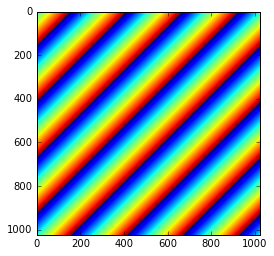

In [54]:
%matplotlib inline
from matplotlib.pyplot import imshow

imshow(img)